In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(124),
    transforms.CenterCrop(124),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
test_transform = transforms.Compose([
    transforms.Resize(124),
    transforms.CenterCrop(124),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [12]:
root = "/kaggle/input/dogs-vs-cats"
train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)
torch.manual_seed(42)
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)
class_names = train_data.classes

In [20]:
class_names

['cats', 'dogs']

In [21]:
len(train_data)

20000

In [22]:
len(test_data)

5000

In [16]:
for images,labels in train_loader:
    break

In [24]:
images.shape

torch.Size([10, 3, 124, 124])

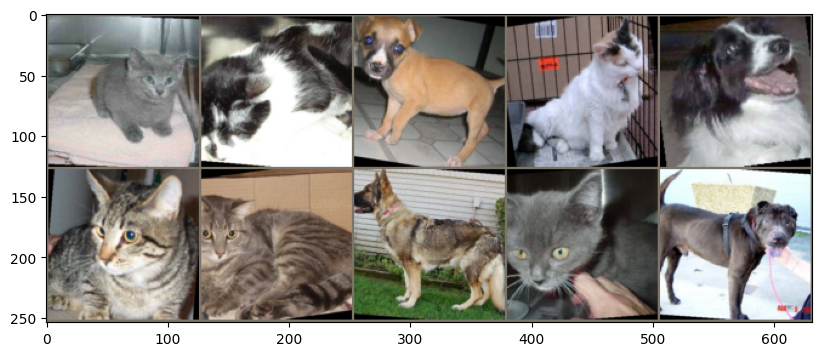

In [17]:
im = make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(29*29*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,29*29*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [27]:
torch.manual_seed(101)
CNNModel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNModel.parameters(),lr=0.001)

In [28]:
CNNModel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [29]:
for p in CNNModel.parameters():
    print(p.numel())

162
6
864
16
1614720
120
10080
84
168
2


In [30]:
import time
start_time = time.time()
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred = CNNModel(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%200==0:
            print(f'Epoch {i} Loss {loss.item()}')
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = CNNModel(X_test)
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    loss = criterion(y_val,y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
total_time = time.time() - start_time
print('Total Time: {total_time/60} minutes')

Epoch 0 Loss 0.7883509993553162
Epoch 0 Loss 0.6252601146697998
Epoch 0 Loss 0.6220905780792236
Epoch 0 Loss 0.8071609735488892
Epoch 0 Loss 0.6758695244789124
Epoch 0 Loss 0.47595053911209106
Epoch 0 Loss 0.518429160118103
Epoch 0 Loss 0.7961769104003906
Epoch 0 Loss 0.6100705862045288
Epoch 0 Loss 0.49890369176864624
Epoch 1 Loss 0.43654194474220276
Epoch 1 Loss 0.2597268521785736
Epoch 1 Loss 0.572029173374176
Epoch 1 Loss 0.34495875239372253
Epoch 1 Loss 0.3846598267555237
Epoch 1 Loss 0.515361487865448
Epoch 1 Loss 0.38491302728652954
Epoch 1 Loss 0.22359439730644226
Epoch 1 Loss 0.4546175003051758
Epoch 1 Loss 0.48430460691452026
Epoch 2 Loss 0.3120688199996948
Epoch 2 Loss 0.4709016680717468
Epoch 2 Loss 0.25194644927978516
Epoch 2 Loss 0.3866647183895111
Epoch 2 Loss 0.40590494871139526
Epoch 2 Loss 0.4935517907142639
Epoch 2 Loss 0.4375961422920227
Epoch 2 Loss 0.2727350890636444
Epoch 2 Loss 0.4051426351070404
Epoch 2 Loss 0.29487019777297974
Epoch 3 Loss 0.6085262298583984
E

In [31]:
print(f'Total Time: {total_time/60} minutes')

Total Time: 29.909341049194335 minutes


In [32]:
torch.save(CNNModel.state_dict(),'Cats_vs_Dogs_CNN.pt')

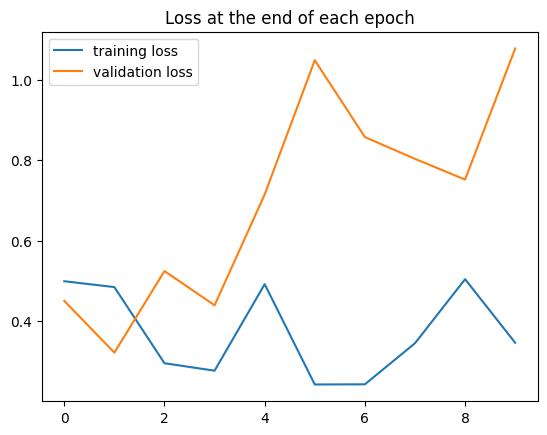

In [33]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

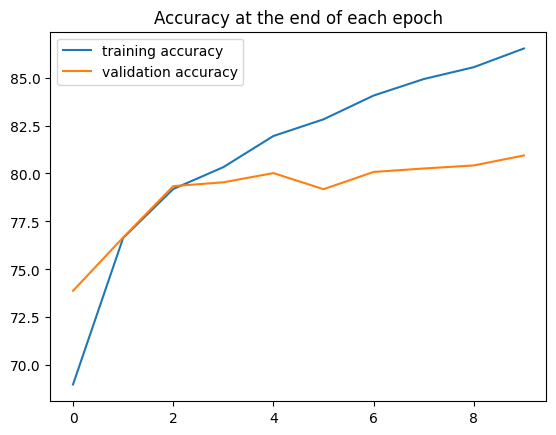

In [46]:
plt.plot([t/200 for t in train_correct], label='training accuracy')
plt.plot([t/50 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [49]:
# print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/5000:.2f}%')

Test accuracy: 80.94%


In [2]:
AlexNetModel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 184MB/s]  


In [3]:
for params in AlexNetModel.parameters():
    params.requires_grad = False

In [4]:
torch.manual_seed(42)
AlexNetModel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(1024,2),
                                       nn.LogSoftmax(dim=1))

In [5]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [6]:
for params in AlexNetModel.parameters():
    print(params.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(),lr=0.001)

In [13]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetModel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.03476938  accuracy:  83.750%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.04932067  accuracy:  85.075%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.51631945  accuracy:  85.600%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.13206248  accuracy:  85.938%

Duration: 192 seconds


In [15]:
print(test_correct[-1].item()/3000)

0.8736666666666667


In [21]:
torch.save(AlexNetModel.state_dict(),'Cats_vs_Dogs_AlexNet.pt')

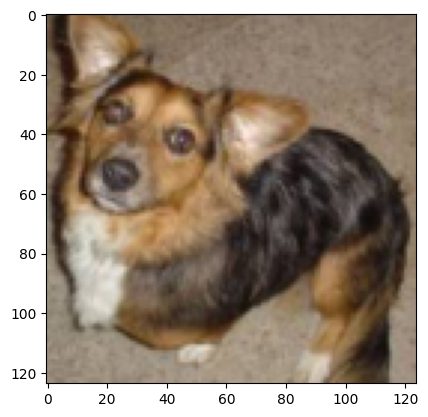

In [32]:
image_index = 4250
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(),[1,2,0]))

In [5]:
CNNModel2 = ConvolutionalNetwork()

In [7]:
CNNModel2.load_state_dict(torch.load('/kaggle/input/cats_vs_dogs_models/pytorch/default/1/Cats_vs_Dogs_CNN.pt'));
CNNModel2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [33]:
with torch.no_grad():
    new_pred = CNNModel2(test_data[image_index][0].view(1,3,124,124)).argmax()
class_names[new_pred.item()]

'dogs'

In [22]:
AlexNetModel2 = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 194MB/s]  


In [24]:
for params in AlexNetModel2.parameters():
    params.requires_grad = False
torch.manual_seed(42)
AlexNetModel2.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(1024,2),
                                       nn.LogSoftmax(dim=1))

In [25]:
AlexNetModel2

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [26]:
for params in AlexNetModel2.parameters():
    print(params.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [27]:
AlexNetModel2.load_state_dict(torch.load('/kaggle/input/cats_vs_dogs_models/pytorch/default/1/Cats_vs_Dogs_AlexNet.pt'));
AlexNetModel2.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [34]:
with torch.no_grad():
    new_pred2 = AlexNetModel2(test_data[image_index][0].view(1,3,124,124)).argmax()
class_names[new_pred2.item()]

'dogs'

In [38]:
from PIL import Image

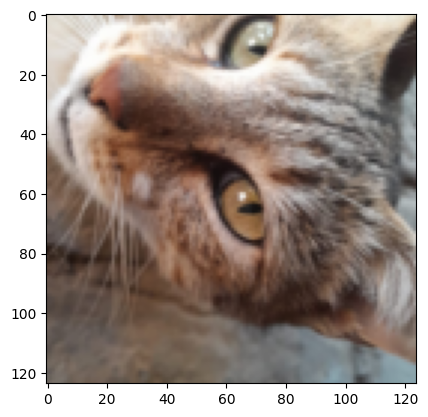

In [60]:
image_path = '/kaggle/input/test-cat/test_cat_data/IMG-20241013-WA0013.jpg'
image = Image.open(image_path).convert('RGB')
image = test_transform(image)
im = inv_normalize(image)
plt.imshow(np.transpose(im.numpy(),[1,2,0]))

In [61]:
with torch.no_grad():
    new_pred = CNNModel2(image.view(1,3,124,124)).argmax()
class_names[new_pred.item()]

'dogs'

In [62]:
with torch.no_grad():
    new_pred2 = AlexNetModel2(image.view(1,3,124,124)).argmax()
class_names[new_pred2.item()]

'cats'